In [182]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import csv
#import pandasql as ps
import matplotlib.pyplot as plt
#import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
#import pysal as ps
import scipy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data

from torch.nn import functional
from torch.autograd import Variable

import statistics

#temporal pattern clustering
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster
from scipy.stats import chisquare
from scipy.stats import wasserstein_distance

#regression model
from patsy import dmatrices
#import statsmodels.api as sm

from datetime import datetime

#from pysal.model import spreg
#from pysal.lib import weights
#from pysal.explore import esda

#calculate the demographic bias 
#use wasserstein_distance
from scipy.stats import wasserstein_distance

#path = 'C:/Users/29700/Downloads/RecSys-Workshop/tutorials/'
#os.chdir(path)
#import utilities as utl

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mae
from datetime import datetime
import time
from sklearn.decomposition import NMF

import time
import scipy.sparse
from scipy.stats import entropy
from sys import exit

import itertools
from itertools import permutations

import xml.etree.ElementTree as ET

import geopandas as gpd

In [336]:
path = "G:/My Drive/2021/Bias/sumo_simulation/appsim"
os.chdir(path)
#os.listdir()

In [376]:
#read app-based data
csv_path = '../data-1670309862526.csv'
#def convertobs2mx(csv_path,)
data_obs = pd.read_csv(csv_path, header=0)
data_obs.head(3)

newid  sum         key  taz  date  time
0     26    1  4_3_55_608  608     4  3:55
1     26    2   4_4_5_615  615     4  4:05
2     26    1  4_3_40_578  578     4  3:40

In [380]:
newids = np.unique(data_obs.newid)
newid_ = {}
index_ = 0
for i in range(len(newids)):
    newid_[newids[i]] = index_
    index_ += 1

In [381]:
get_hr = lambda x: x.split(':')[0]
get_min = lambda x: x.split(':')[1]

hr_ = np.unique(data_obs['time'].astype(str).apply(get_hr).astype(int))
min_ = np.unique(data_obs['time'].astype(str).apply(get_min).astype(int))
taz_ = np.unique(data_obs['taz'])

data_obs['hr'] = data_obs['time'].astype(str).apply(get_hr).astype(int)
data_obs['min'] = data_obs['time'].astype(str).apply(get_min).astype(int)

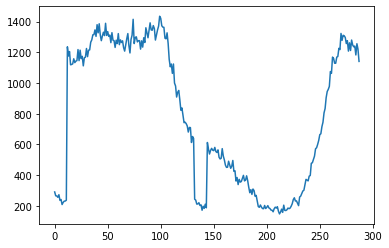

In [385]:
index_ = 0
lt_loc = {}
for taz in taz_:
    for h in hr_:
        for m in min_:
            lt_loc['4_'+str(h)+'_'+str(m)+'_'+str(taz)] = index_
            index_ += 1
obs_mx = np.zeros((len(newid_), len(lt_loc)))

newid_col = data_obs.newid.values
key_col = data_obs.key.values
ct_col = data_obs['sum'].values

for i in range(len(newid_col)):
    obs_mx[newid_[newid_col[i]]][lt_loc[key_col[i]]] = 1
    
total_ct = np.sum(obs_mx, axis=0)
#get ct based on taz and time

total_ct = total_ct.reshape(1, total_ct.shape[0])

total_ct_conver = np.hsplit(total_ct, len(taz_))

max_num = np.max(np.array(total_ct_conver), axis=2)

plt.plot(data_obs.groupby(by=['time']).size().values)

In [19]:
#convert dt to matrix
def convert2mx(fcd_dt_path, savepath, save_index=False):
    fcd_out = pd.read_csv(fcd_dt_path, header=None)
    fcd_out.columns = ['id', 'taz', 'time']
    fcd_out.taz = fcd_out.taz.astype('int')
    fcd_out.time = fcd_out.time.astype('int')
    print('num id', len(np.unique(fcd_out.id)))

    #fcd_out.sort_values(by=['time', 'taz'])
    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+((fcd_out['time']/300).astype(int)).astype(str)

    fcd_out = fcd_out[~fcd_out['time'].isin([86400, 86700])]
    time_ = np.unique((fcd_out['time']/300).astype(int))
    newuser_ = {}
    index_ = 0
    for i in np.unique(fcd_out.id):
        newuser_[i] = index_
        index_ += 1

    loc_time = {}
    index_ = 0
    taz_ = np.unique(fcd_out['taz'])
    time_ = np.unique((fcd_out['time']/300).astype(int))
    for taz in taz_:
        for t in time_:
            loc_time[str(taz)+'_'+str(t)] = index_
            index_ += 1

    origin_dt = np.zeros((len(newuser_), len(loc_time)))
    ids_ = fcd_out['id'].values
    tl_id_ = fcd_out['tl_id'].values
    for i in range(len(ids_)):
        origin_dt[newuser_[ids_[i]]][loc_time[tl_id_[i]]] = 1
    if save_index == True:
        pd.DataFrame(origin_dt).to_csv(savepath)
    else:
        return(origin_dt)
    
origin_dt = convert2mx('fcd_data_5.csv', 'origin_dt.csv', save_index=False)

num id 60728


In [20]:
fcd_out = pd.read_csv('fcd_data_5.csv', header=None)
fcd_out.columns = ['id', 'taz', 'time']

fcd_out = fcd_out[~fcd_out['time'].isin([86400, 86700])]
fcd_out.taz = fcd_out.taz.astype('int')
fcd_out.time = fcd_out.time.astype('int')
fcd_out['time_5'] = fcd_out.time/300

fcd_out.time_5 = fcd_out.time_5.astype('int')

obs = data_obs.groupby(by=['time']).size().values
obs_per = obs/max(obs)

sample_ct = lambda x: np.random.binomial(1, obs_per[x], 1)[0]

fcd_out['sim_obs'] = fcd_out['time_5'].apply(sample_ct)

fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+((fcd_out['time']/300).astype(int)).astype(str)

In [311]:
#conduct spatial variation
Seattle_taz = gpd.read_file('test_taz_Seattle_1.shp')
#processing the None value
Seattle_taz['nb_t'].loc[[list(Seattle_taz['nb_t'].values == None).index(True)]] = '1'
Seattle_taz['nb_agg'] = Seattle_taz['nb']+','+Seattle_taz['nb_touch']+','+Seattle_taz['nb_inter']+','+Seattle_taz['nb_t']

#functions

def get_nbtaz(agg_val):
    nb_taz = []
    for taz in agg_val.split(','):
        nb_taz.append(int(taz))
    return(np.unique(nb_taz))

def get_taz_nb_dict(taz_lst, nb_agg_lst, selected_taz):
    taz_nb_dict = {}
    index_ = 0
    for taz in taz_lst:
        if taz in selected_taz:
           # print(taz)
           # print(index_)
            taz_nb_dict[taz] = get_nbtaz(nb_agg_lst[index_])
        index_ += 1
    return(taz_nb_dict)

def process_taz(nb_arr, taz, selected_taz):
    nb_cur = []
    for i in nb_arr:
        if i in selected_taz:
            nb_cur.append(i)
            
    #remove the origin taz in the taz lst
    nb_cur.remove(taz)
    return(nb_cur)

Seattle_taz_nb = get_taz_nb_dict(list(Seattle_taz['TAZ'].values),
                                list(Seattle_taz['nb_agg'].values),
                                taz_)

#process the neighborhood taz, delete all inavailable tazs (not within
#downtown Seattle)
for taz in Seattle_taz_nb:
    Seattle_taz_nb[taz] = process_taz(Seattle_taz_nb[taz], taz, taz_)
    
del(Seattle_taz)

C:\Users\29700\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [325]:
#spatial variation simulaiton
#given a probability follows bernoulli distribution
#if true, the point stays in the original taz, otherwise randomly assign
#the neighborhood taz to it
taz = 426
per = .8
index_ = np.random.binomial(1, per, 1)[0]
if index_==0:
    print(random.choice(Seattle_taz_nb[taz]))
else:
    print(taz)

426


In [479]:
time_loc = {}
index_ = 0
for hr in hr_:
    for miuts in min_:
        time_loc[str(hr)+'_'+str(miuts)] = index_
        index_ += 1
        
def get_time_variationbyzone(data, taz, time_loc):
    data_taz = data[data['taz']==taz]
    data_taz = data_taz.sort_values(by=['hr', 'min'])
    data_taz = data_taz.groupby(by=['hr', 'min']).sum()
    
    data_taz.reset_index(inplace=True)
    data_taz = data_taz[['hr','min','sum']]
    #data_taz
    obs_sum = np.zeros((len(time_loc)))
    hr_ = data_taz['hr'].values
    min_ = data_taz['min'].values
    sum_val = data_taz['sum'].values
    
    for i in range(len(hr_)):
        obs_sum[time_loc[str(hr_[i])+'_'+str(min_[i])]] = sum_val[i]
    #use obs/max(obs) instead of obs/sum(obs) 
    obs_per = obs_sum/(np.max(obs_sum))
    
    fig = plt.figure(taz)
    plt.plot(obs_sum)
    return(obs_per)



C:\Users\29700\AppData\Local\Temp\ipykernel_6592\2337170958.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(taz)


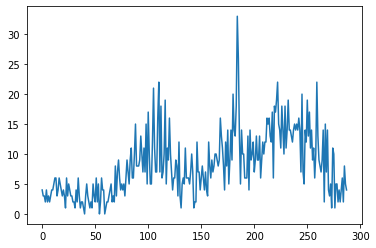

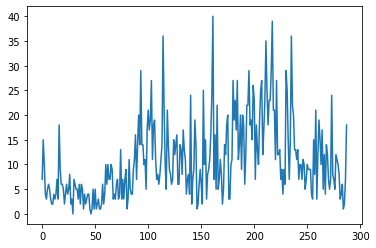

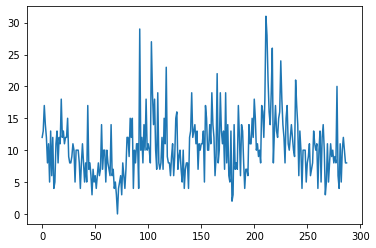

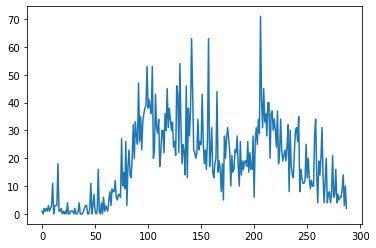

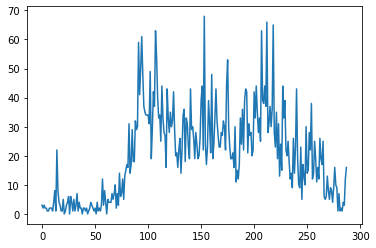

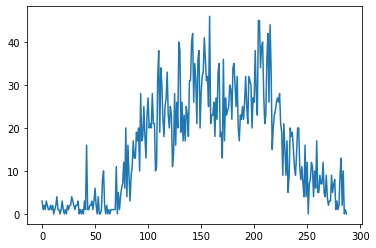

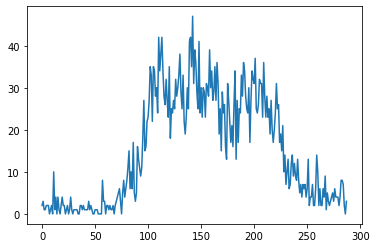

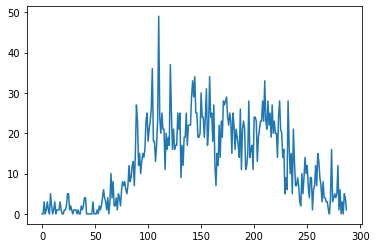

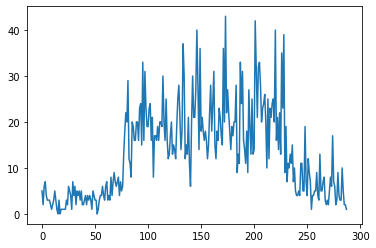

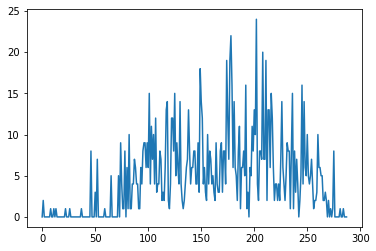

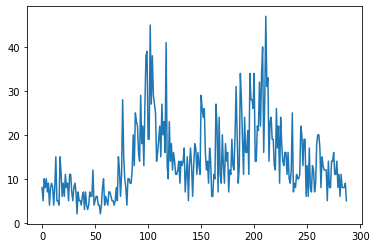

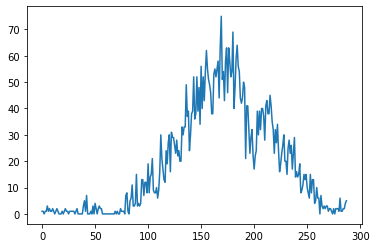

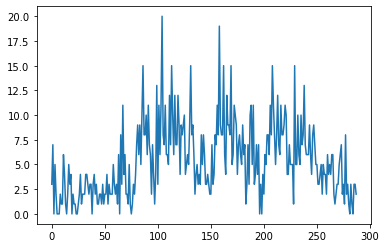

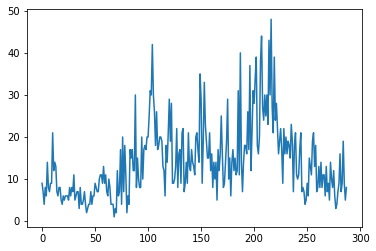

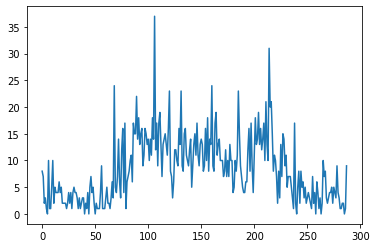

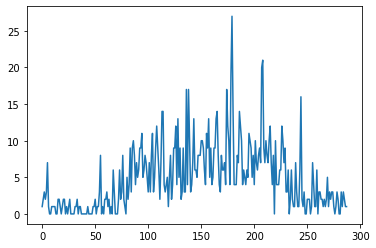

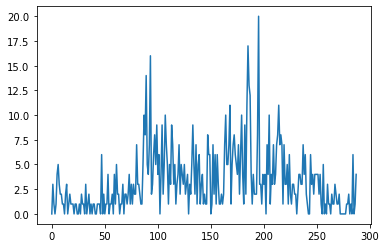

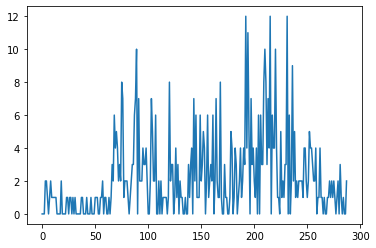

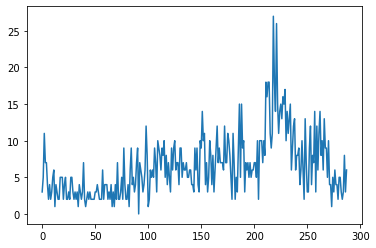

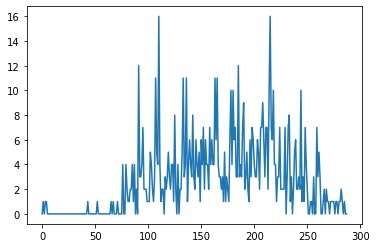

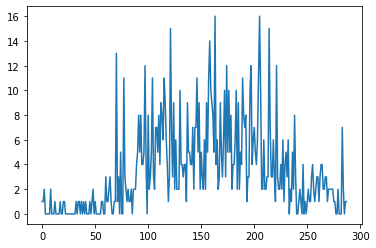

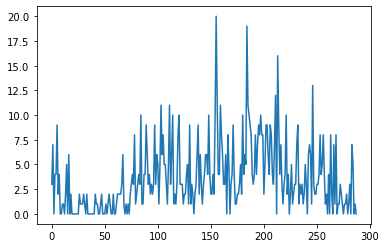

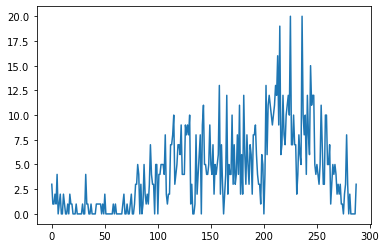

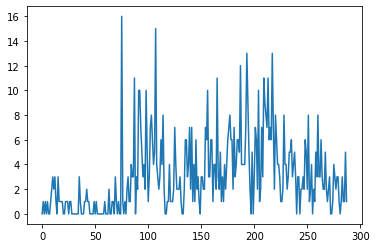

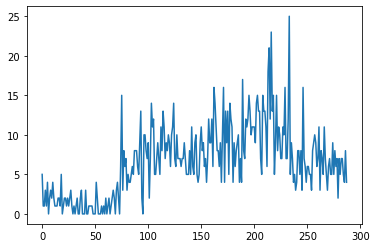

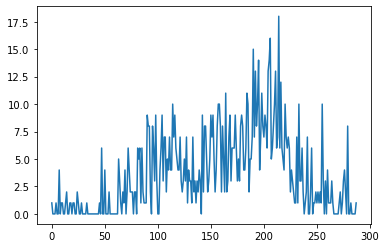

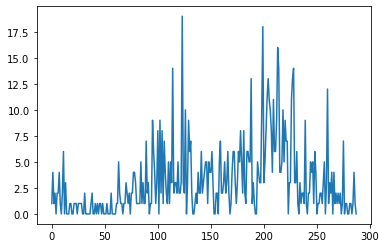

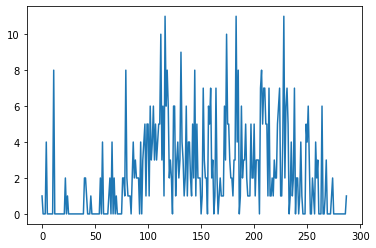

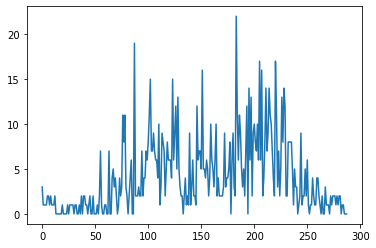

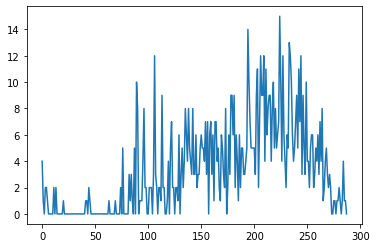

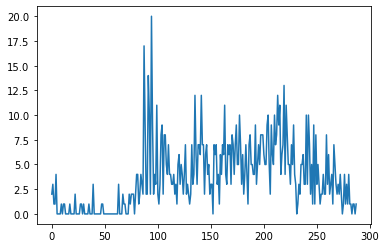

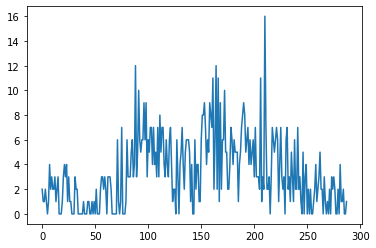

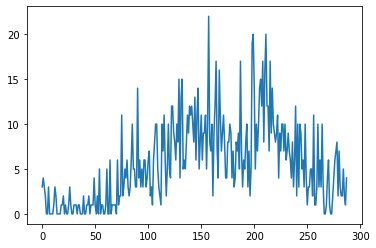

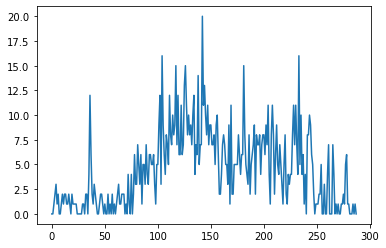

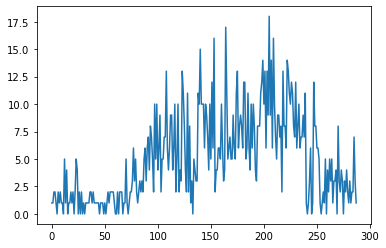

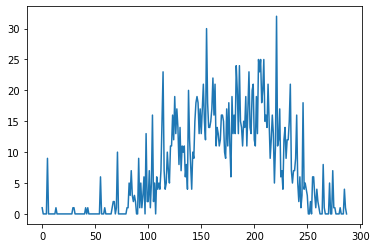

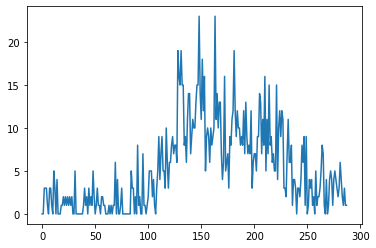

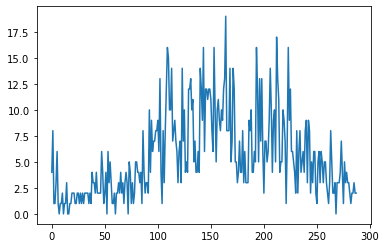

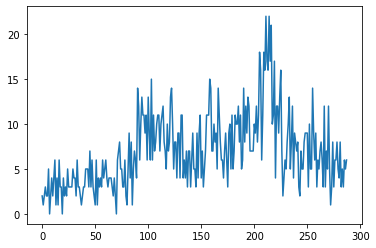

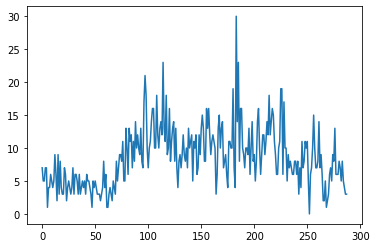

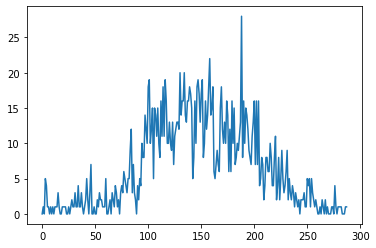

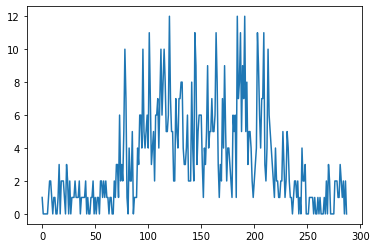

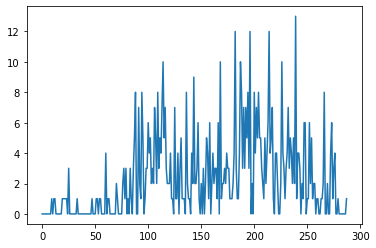

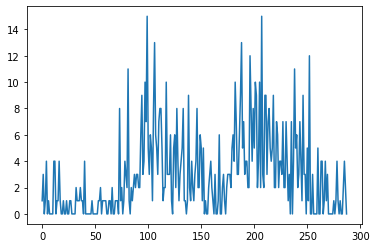

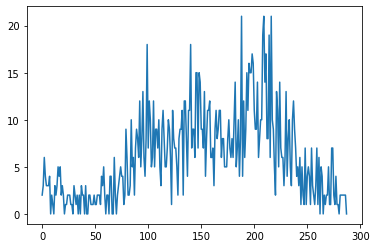

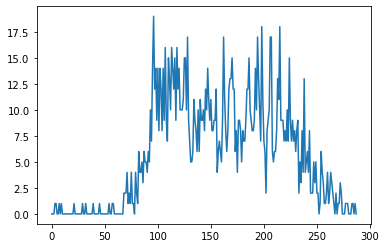

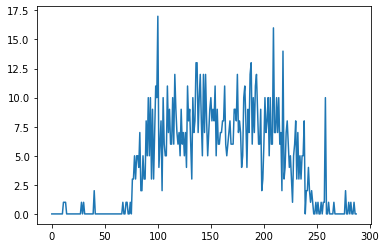

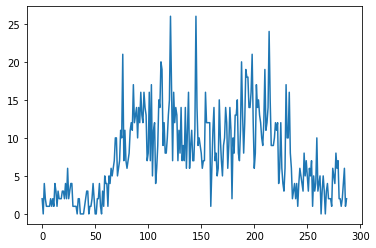

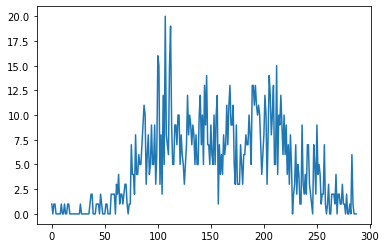

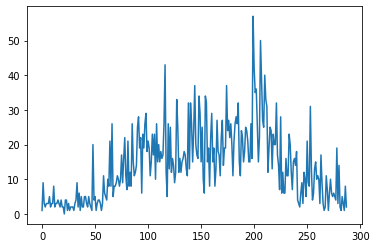

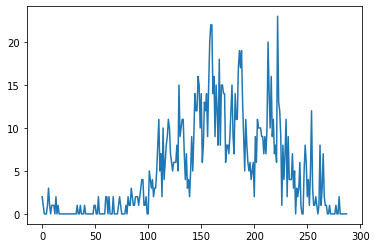

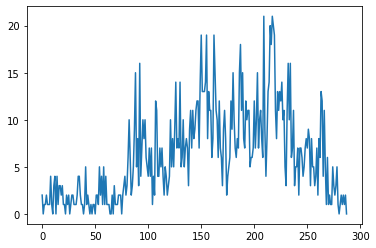

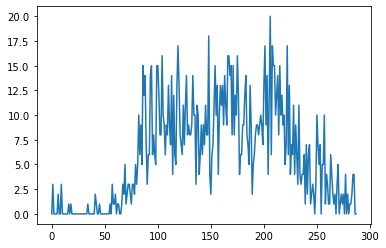

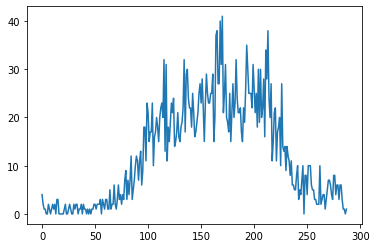

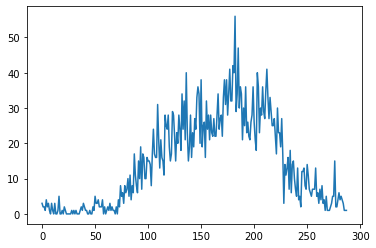

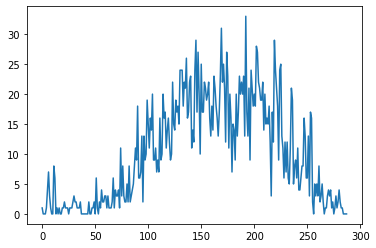

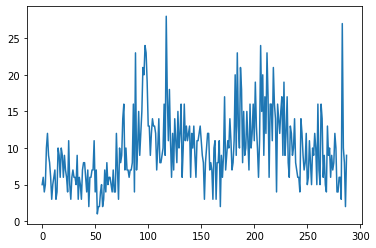

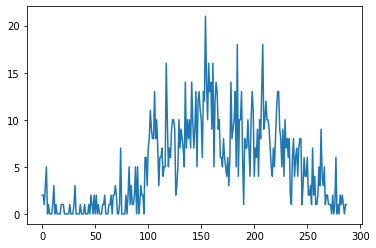

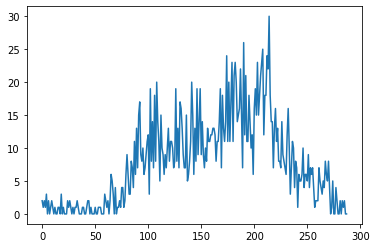

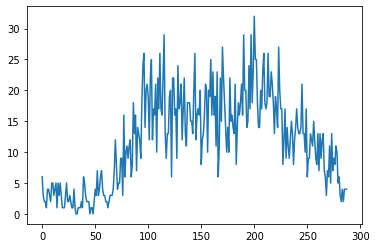

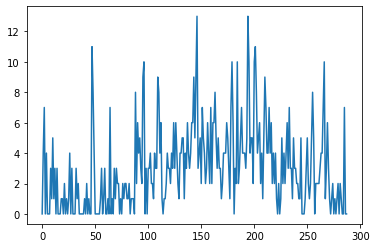

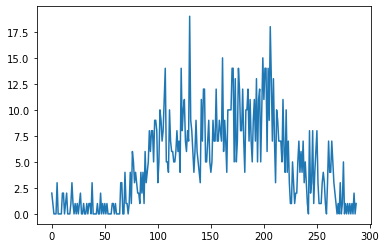

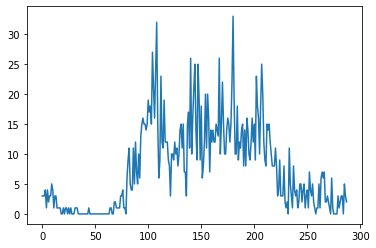

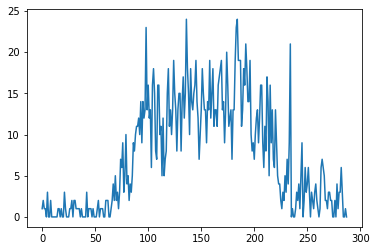

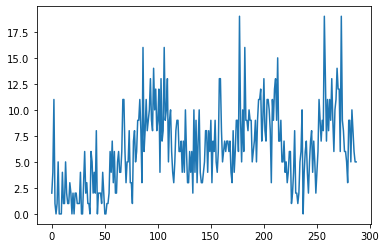

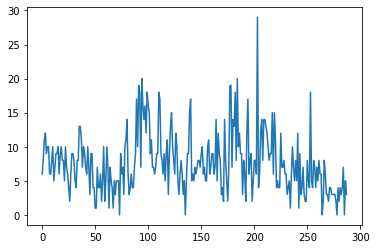

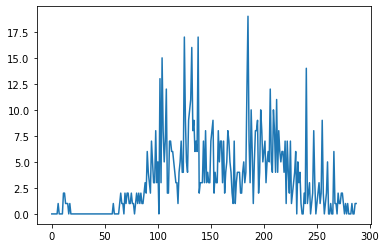

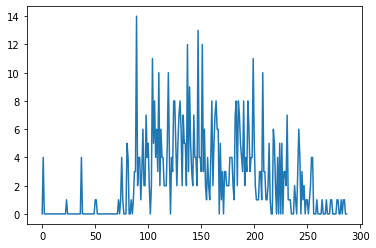

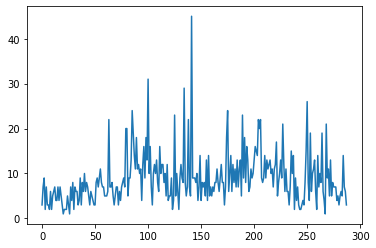

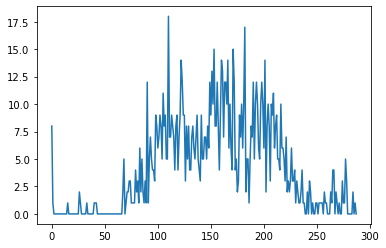

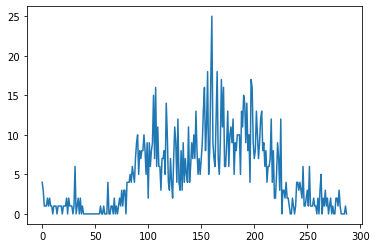

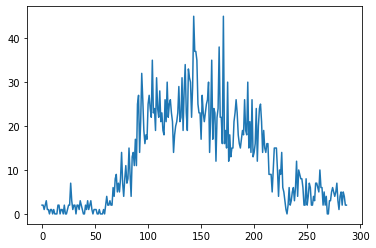

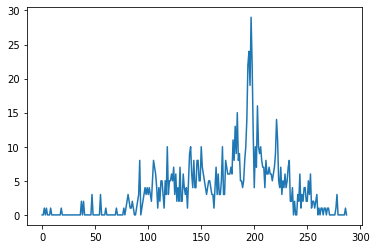

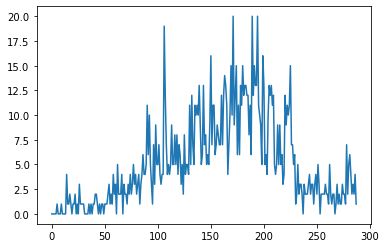

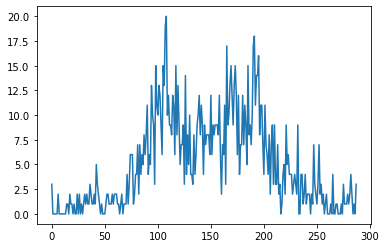

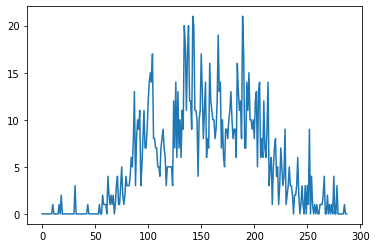

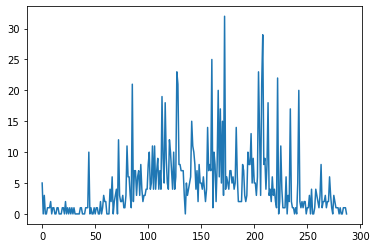

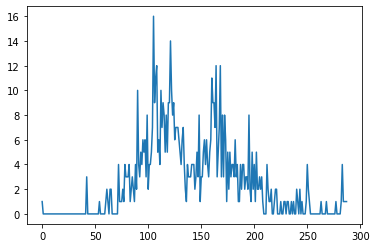

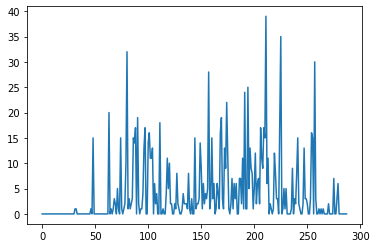

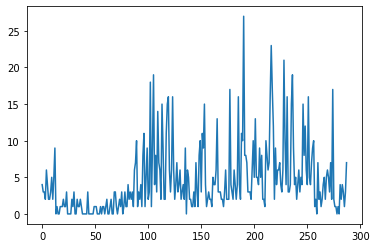

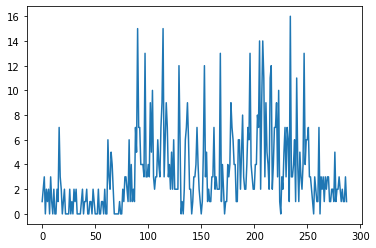

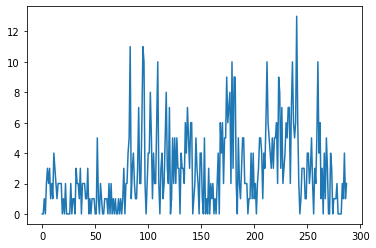

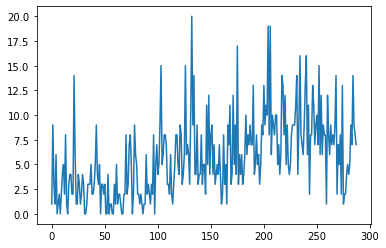

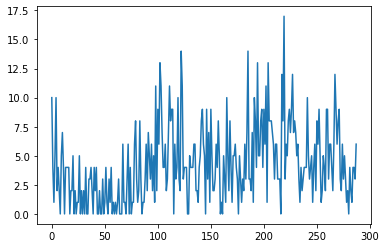

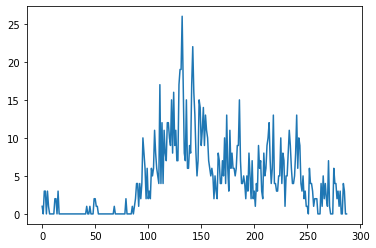

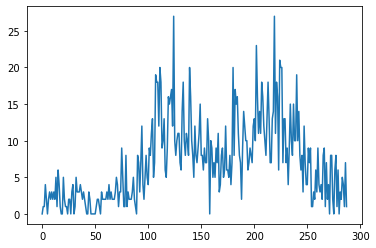

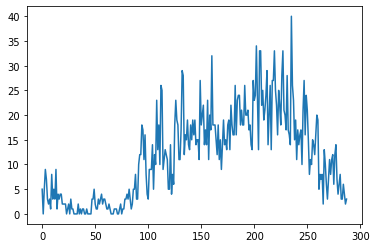

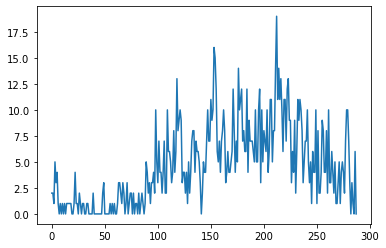

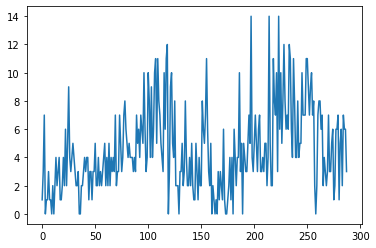

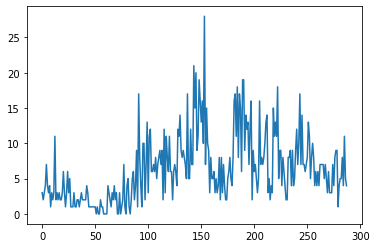

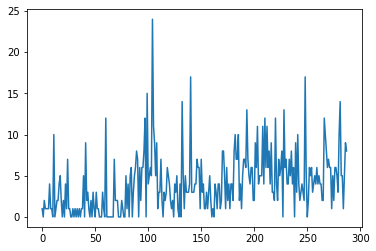

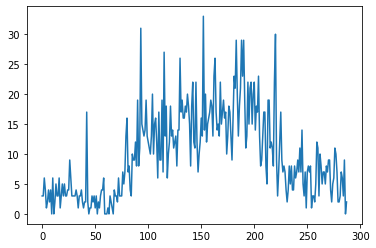

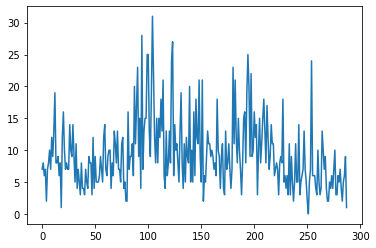

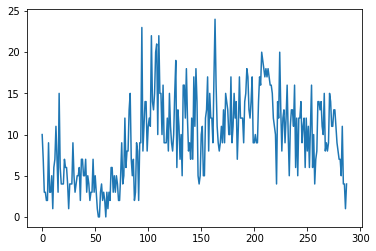

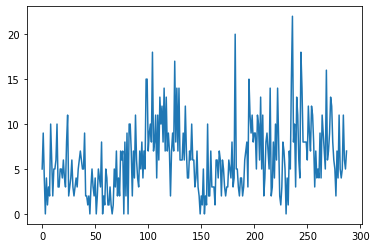

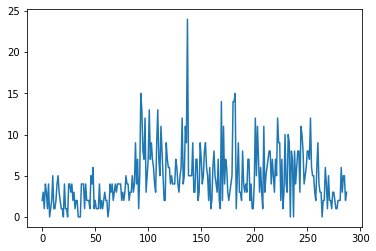

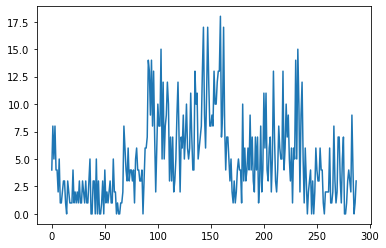

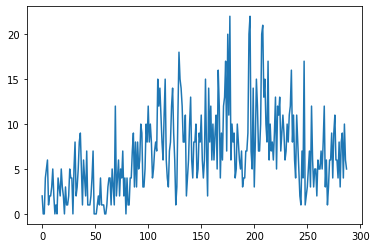

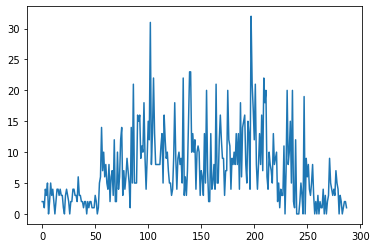

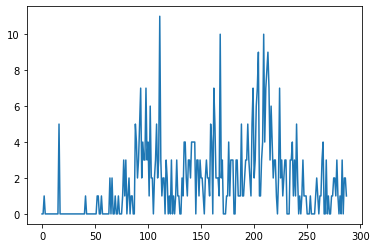

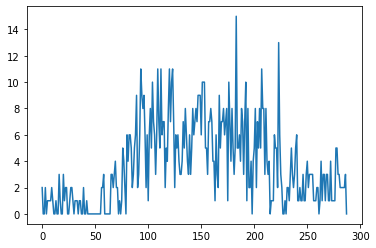

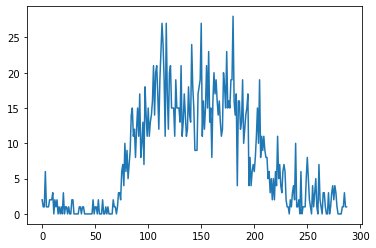

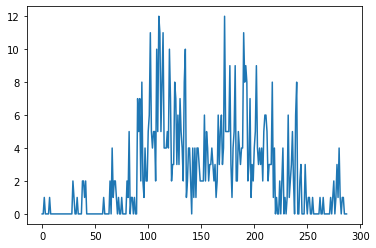

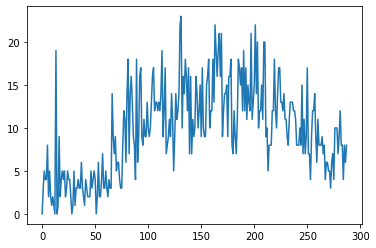

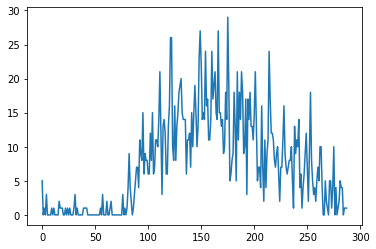

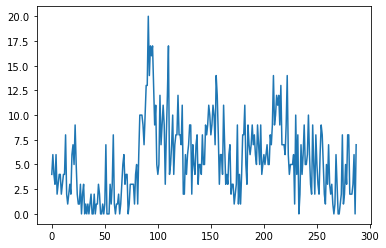

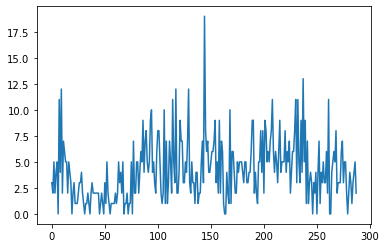

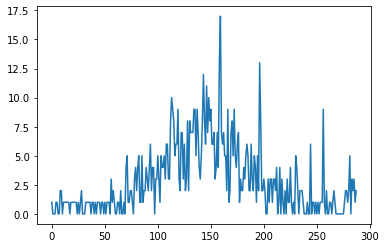

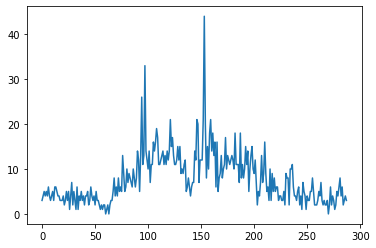

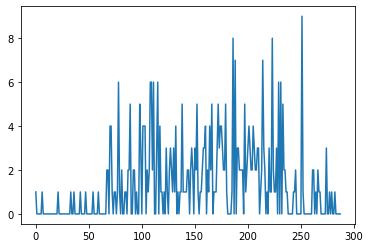

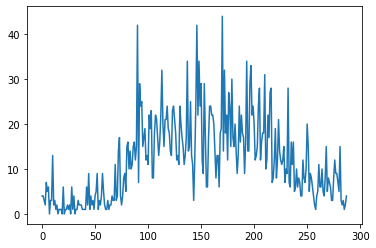

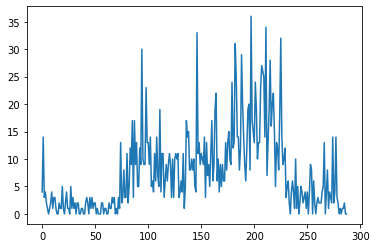

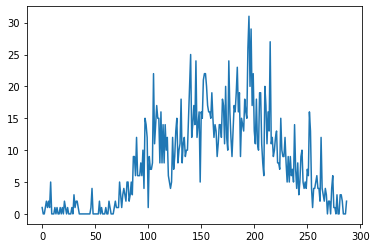

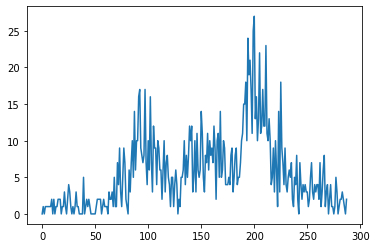

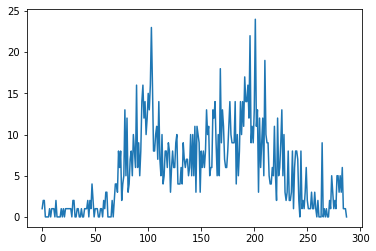

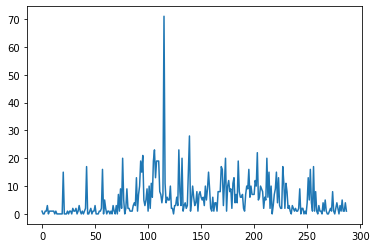

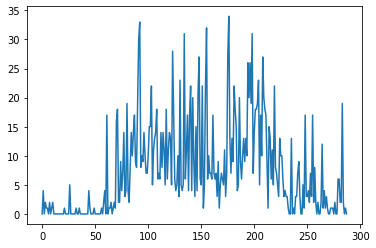

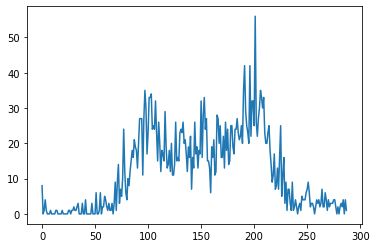

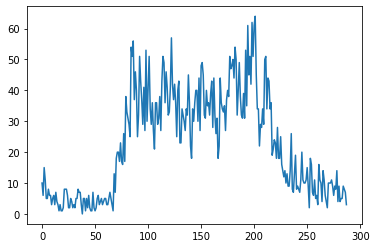

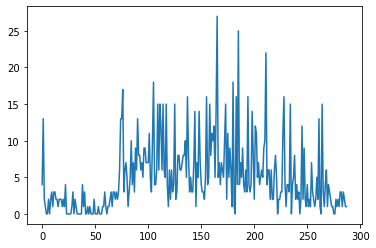

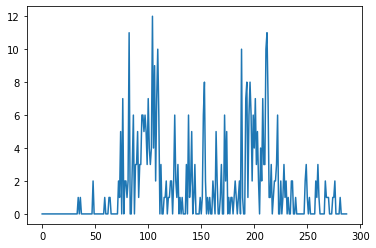

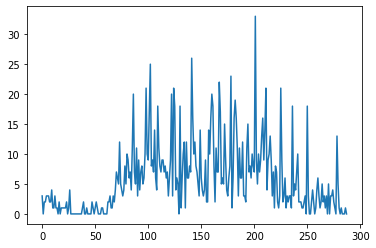

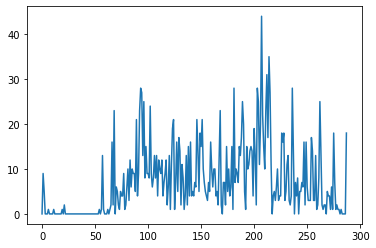

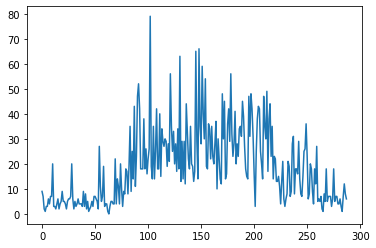

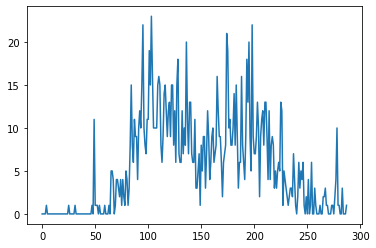

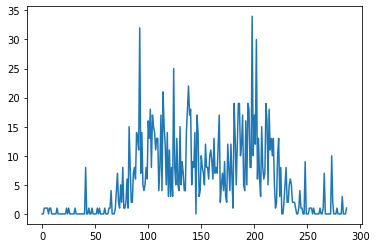

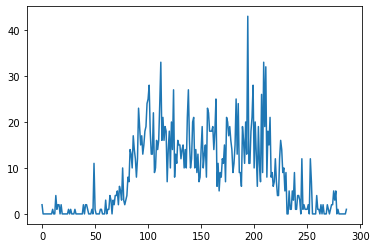

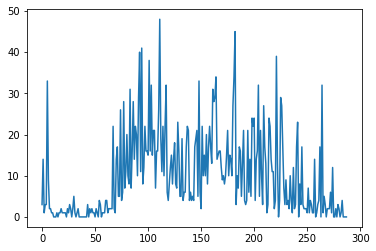

In [480]:
taz_time_per = {}
avg_per = 0
index_ = 0 
for taz_id in taz_:
    taz_time_per[taz_id] = get_time_variationbyzone(data_obs, taz_id, time_loc)
    if index_ == 0:
        avg_per = taz_time_per[taz_id]
    else:
        avg_per = avg_per + taz_time_per[taz_id]
    index_ += 1

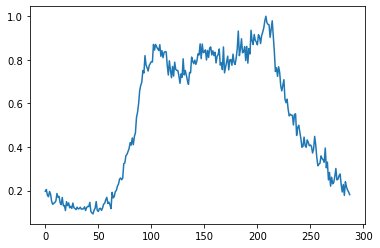

In [485]:
avg_per = avg_per/np.max(avg_per)
plt.plot(avg_per)

In [486]:
def get_sim_obs_ts(fcd_out, taz_time_per, avg_per, return_sim=True):
    taz_ = fcd_out['taz'].values
    time_5 = fcd_out['time_5'].values
    per_ts = []
    for i in range(len(taz_)):
        if taz_[i] in taz_time_per:
            per_ts.append(taz_time_per[taz_[i]][time_5[i]])
        else:
            per_ts.append(avg_per[time_5[i]])
    if return_sim == True:
        sim_obs_ts = [] 
        for i in range(len(per_ts)):
            sim_obs_ts.append(np.random.binomial(1, per_ts[i], 1)[0])
        return(sim_obs_ts)
    else:
        return(per_ts)
        

In [ ]:
sim_obs = get_sim_obs_ts(fcd_out, taz_time_per, avg_per, True)
fcd_out['sim_obs_ts'] = sim_obs

In [492]:
#simulated observations based on time variation
print('sim based on time', 
      np.count_nonzero(fcd_out['sim_obs'])/fcd_out.shape[0])

#simulated observations based on time and spatial variation
print('sim based on time and spatial',
      np.count_nonzero(fcd_out['sim_obs_ts'])/fcd_out.shape[0])

sim based on time 0.42954262736135623
sim based on time and spatial 0.36062574131396996


In [493]:
fcd_out.columns

Index(['id', 'taz', 'time', 'time_5', 'sim_obs', 'tl_id', 'sim_obs_ts'], dtype='object')

In [ ]:
newuser_ = {}
index_ = 0
for i in np.unique(fcd_out.id):
    newuser_[i] = index_
    index_ += 1

loc_time = {}
index_ = 0
taz_ = np.unique(fcd_out['taz'])
time_ = np.unique((fcd_out['time']/300).astype(int))
for taz in taz_:
    for t in time_:
        loc_time[str(taz)+'_'+str(t)] = index_
        index_ += 1

In [498]:
def get_simdt(fcd_out, sim_col, newuser_, loc_time):
    sim_dt = np.zeros((len(newuser_), len(loc_time)))
    ids_ = fcd_out['id'].values
    tl_id_ = fcd_out['tl_id'].values
    ct_ = fcd_out[sim_col].values
    for i in range(len(ids_)):
        sim_dt[newuser_[ids_[i]]][loc_time[tl_id_[i]]] = ct_[i]
    return(sim_dt)

In [ ]:
sim_dt_t = get_simdt(fcd_out, 'sim_obs')

In [499]:
sim_dt_ts = get_simdt(fcd_out, 'sim_obs_ts', newuser_, loc_time)

In [500]:
sim_dt_ts.shape

(60711, 48384)

In [297]:
#example of NMF
#X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [27]:
model = NMF(n_components=100, init='random', random_state=0)
W = model.fit_transform(sim_dt)
H = model.components_

WH = np.dot(W, H)
#therefore we have
#origin_dt (ground truth)
#sim_dt (time variation based sampling)
#WH (nmf pred based on sim_dt)

C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [181]:
#check rmse
#mean_squared_error(origin_dt, sim_dt, squared=False)
#0.003269806981300681
#mean_squared_error(origin_dt, WH, squared=False)
#0.005064870617568365
#mean_squared_error(sim_dt, WH, squared=False)
#0.0028294665247159886

#save the predicted W and H
#pd.DataFrame(W).to_csv('W_time.csv')
#pd.DataFrame(H).to_csv('H_time.csv')